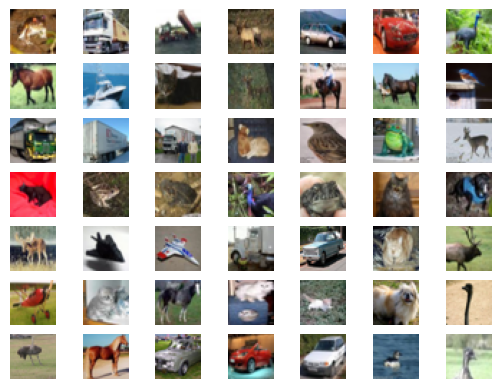

In [33]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot as plt

(trainX,trainy),(testX,testy) = load_data()

for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

In [34]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten,Dropout,LeakyReLU
from keras.utils import plot_model
import numpy as np

In [35]:
def define_discriminator(in_shape = (32,32,3)):
    model = Sequential()
    model.add(Conv2D(64,(3,3),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))
    
    opt = Adam(learning_rate=0.002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [36]:
model = define_discriminator()
model.summary()
plot_model(model,to_file='discriminator_plot.png',show_shapes=True,show_layer_names=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 256)        

In [37]:
def load_rel_samples():
    (trainX,_),(_,_) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5)/127.5
    return X

In [38]:
def generate_rel_samples(dataset,n_samples):
    ix = np.random.randint(0,dataset.shape[0],n_samples)
    X = dataset[ix]
    y = np.ones((n_samples,1))
    return X,y

In [39]:
def generate_fake_images(dataset,n_samples):
    X = np.random.rand(32*32*3*n_samples)
    X=-1+X*2
    X=X.reshape((n_samples,32,32,3))
    y = np.zeros((n_samples,1))
    return X,y

In [40]:
def train_discriminator(model,dataset,n_iter=20,n_batch = 128):
    half_batch = int(n_batch/2)
    for i in range(n_iter):
        X_real,y_real = generate_rel_samples(dataset,half_batch)
        _,real_acc = model.train_on_batch(X_real,y_real)
        X_fake,y_fake = generate_fake_images(dataset,half_batch)
        _,fake_acc = model.train_on_batch(X_fake,y_fake)
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1,real_acc*100,fake_acc*100))

In [41]:
model = define_discriminator()
dataset = load_rel_samples()
train_discriminator(model,dataset)

>1 real=38% fake=0%
>2 real=8% fake=0%
>3 real=81% fake=66%
>4 real=91% fake=97%
>5 real=91% fake=100%
>6 real=95% fake=100%
>7 real=98% fake=100%
>8 real=100% fake=100%
>9 real=100% fake=100%
>10 real=100% fake=100%
>11 real=100% fake=100%
>12 real=100% fake=100%
>13 real=100% fake=100%
>14 real=100% fake=100%
>15 real=100% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


In [42]:
from keras.layers import Conv2DTranspose,Reshape

In [43]:
def define_generator(latent_dim):
    model = Sequential()
    n_node = 256*4*4
    model.add(Dense(n_node,input_dim = latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))
    return model

In [44]:
latent_dim=100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 128)         524416    
 Transpose)                                                      
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                           

In [45]:
def generate_latent_points(latent_dim,n_samples):
    x_input = np.random.randn(latent_dim*n_samples)
    x_input = x_input.reshape(n_samples,latent_dim)
    return x_input

In [46]:
def generate_fake_samples(g_model,latent_dim,n_samples):
    x_input = generate_latent_points(latent_dim,n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples,1))
    return X,y

2/2 [==============================] - 1s 130ms/step


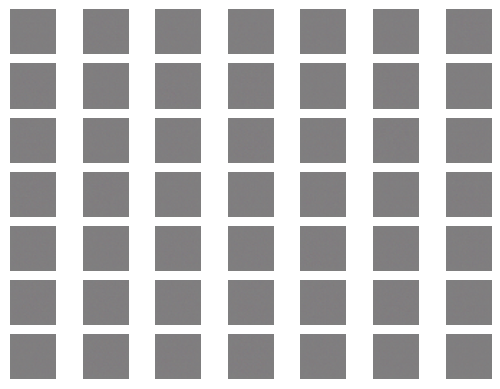

In [47]:
latent_dim = 100
model = define_generator(latent_dim)
n_samples = 49
X,_ = generate_fake_samples(model,latent_dim,n_samples)
X = (X + 1)/2.0
for i in range(n_samples):
    plt.subplot(7,7,1+i)
    plt.axis('off')
    plt.imshow(X[i])
plt.show()

In [48]:
def define_GAN(g_model,d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt= Adam(learning_rate = 0.0002,beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy',optimizer = opt)
    return model

In [70]:
def train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs = 200,n_batch =128):
    batch_per_epoch = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real,y_real = generate_rel_samples(dataset,half_batch)
            dloss1 = d_model.train_on_batch(X_real,y_real)
            X_fake,y_fake = generate_fake_samples(g_model,latent_dim,half_batch)
            dloss2 = d_model.train_on_batch(X_fake,y_fake)
            x_gan = generate_latent_points(latent_dim,n_batch)
            y_gan = np.ones((n_batch,1))
            gloss = gan_model.train_on_batch(x_gan,y_gan)
    
            print('>%d, %d,%d, d1=%.3f,d2=%.3f g=%.3f' % (i+1,j+1,batch_per_epoch,dloss1[0],dloss2[0],gloss))
        if(i+1)%10 == 0:
            summarize_per(i,g_model,d_model,dataset,latent_dim)

In [71]:
def summarize_per(epoch,g_model,d_model,dataset,latent_dim,n_sample=150):
    X_real,y_real = generate_rel_samples(dataset,n_sample)
    _,acc_real = d_model.evaluate(X_real,y_real,verbose=0)
    x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_sample)
    _,acc_fake = d_model.evaluate(x_fake,y_fake,verbose=0)
    print('>Accuracy real : %.0f%%, fake : %.0f%%' % (acc_real*100,acc_fake*100))
    save_plot(x_fake,epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [72]:
def save_plot(examples,epoch,n=7):
    examples = (examples+1)/2.0
    for i in range(n*n):
        plt.subplot(n,n,1+i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = 'generator_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [73]:
latent_dim= 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_GAN(g_model,d_model)


In [ ]:
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=200,n_batch=128)